# **Hi-C Analysis Demo**

First, let's download the data for this notebook.

The following commands will download (`wget`) the file `hic-analysis-demo.tar.gz` and then unarchive and decompress it (`tar`), resulting in the folder `hic-analysis-demo/`.
Then, the folder will be renamed (`mv`) to `data/`, and the now superfluous file `hic-analysis-demo.tar.gz` will be removed (`rm`).

In [1]:
! wget http://www.tnt.uni-hannover.de/edu/vorlesungen/AMLG/data/hic-analysis-demo.tar.gz
! tar -xzvf hic-analysis-demo.tar.gz
! mv -v hic-analysis-demo/ data/
! rm -v hic-analysis-demo.tar.gz

--2024-08-05 12:08:23--  http://www.tnt.uni-hannover.de/edu/vorlesungen/AMLG/data/hic-analysis-demo.tar.gz
Resolving www.tnt.uni-hannover.de (www.tnt.uni-hannover.de)... 130.75.31.71
Connecting to www.tnt.uni-hannover.de (www.tnt.uni-hannover.de)|130.75.31.71|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50050642 (48M) [application/x-gzip]
Saving to: ‘hic-analysis-demo.tar.gz’

hic-analysis-demo.t 100%[===================>]  47.73M   106MB/s    in 0.5s    

2024-08-05 12:08:24 (106 MB/s) - ‘hic-analysis-demo.tar.gz’ saved [50050642/50050642]

hic-analysis-demo/
hic-analysis-demo/GSE63525_GM12878_insitu_primary_30-250k.cool
renamed 'hic-analysis-demo/' -> 'data/'
removed 'hic-analysis-demo.tar.gz'


Next, we use [cooler](https://github.com/open2c/cooler) to load the real-world Hi-C data.

In [2]:
import cooler

cool_data = cooler.Cooler(store="data/GSE63525_GM12878_insitu_primary_30-250k.cool")
print(f"Data resolution: {cool_data.binsize:,} bp")
print(f"Available chromosomes: {cool_data.chromnames}")

Data resolution: 250,000 bp
Available chromosomes: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y', 'MT']


Then we load the [Knight-Ruiz](https://doi.org/10.1093/imanum/drs019) balanced contact matrix of chromosome 1.

In [3]:
selected_chrom = "1"
contact_matrix = cool_data.matrix(balance="KR").fetch(selected_chrom)

Next, we remove NaNs (these occur due to the matrix balancing), zero entries, and unalignable regions from the contact matrix.

In [4]:
import numpy as np

# Remove NaNs
observed_ids = np.argwhere(~np.isnan(contact_matrix))
observed_row_ids = observed_ids[:, 0]
observed_col_ids = observed_ids[:, 1]
observed_contact_matrix_values = contact_matrix[observed_row_ids, observed_col_ids]

# Remove 0.0s
nonzero_mask = ~np.isclose(observed_contact_matrix_values, 0.0)
observed_row_ids = observed_row_ids[nonzero_mask]
observed_col_ids = observed_col_ids[nonzero_mask]
observed_contact_matrix_values = observed_contact_matrix_values[nonzero_mask]

# Remove unalignable regions
unique_observed_ids = np.unique(np.concatenate([observed_row_ids, observed_col_ids]))
observed_row_ids = np.searchsorted(unique_observed_ids, observed_row_ids)
observed_col_ids = np.searchsorted(unique_observed_ids, observed_col_ids)

The number of contacts is inversely related to the (Euclidean) distance in three-dimensional space, since neighboring regions are more likely to interact.
Therefore, we convert the contact matrix $\mathbf{C}$ into a proxy of the Euclidean distance matrix (EDM) $\mathbf{D}$ using a conversion factor $\alpha$:

$$
D_{i,j} = \frac{1}{C^{\alpha}_{i,j}}.
$$

In [5]:
import torch

alpha = -1
observed_ed_mat_values = torch.from_numpy(
    np.power(observed_contact_matrix_values, alpha)
).float()

We initialize a gradient-tracking PyTorch tensor filled with random numbers from a uniform distribution on the interval $[0,1)$.
This is the point set that we want to optimize.

In [6]:
# torch.manual_seed(seed=42)
n_points = len(unique_observed_ids)
predicted_coord_mat = torch.rand(size=(3, n_points), requires_grad=True)

For the optimization procedure, we also need a function to convert our to-be-optimized point set into its corresponding EDM.

In [7]:
def point2edm(coord_mat: torch.Tensor) -> torch.Tensor:
    gram_mat = coord_mat.T @ coord_mat
    diag_vec = torch.diag(gram_mat).reshape(shape=(-1, 1))
    ones_vec = torch.ones((coord_mat.shape[1], 1))
    ed_mat = diag_vec @ ones_vec.T + ones_vec * diag_vec.T - 2 * gram_mat
    return ed_mat

Finally, we optimize the point set using [Adam](https://doi.org/10.48550/arXiv.1412.6980).

In [8]:
optimizer = torch.optim.Adam(params=[predicted_coord_mat], lr=1e-1)

from torch.nn.functional import mse_loss

n_iterations = 1000

for i in range(n_iterations):
    optimizer.zero_grad()
    predicted_ed_mat = point2edm(coord_mat=predicted_coord_mat)
    partial_predicted_ed_mat_values = predicted_ed_mat[
        observed_row_ids, observed_col_ids
    ]
    loss = mse_loss(
        input=partial_predicted_ed_mat_values, target=observed_ed_mat_values
    )
    loss.backward()
    optimizer.step()

    print(f"Iteration [{(i + 1):5}/{n_iterations:5}] | Loss={loss:8f}")

Iteration [    1/ 1000] | Loss=0.341833
Iteration [    2/ 1000] | Loss=0.090709
Iteration [    3/ 1000] | Loss=0.020820
Iteration [    4/ 1000] | Loss=0.006146
Iteration [    5/ 1000] | Loss=0.004087
Iteration [    6/ 1000] | Loss=0.005005
Iteration [    7/ 1000] | Loss=0.007860
Iteration [    8/ 1000] | Loss=0.012004
Iteration [    9/ 1000] | Loss=0.015867
Iteration [   10/ 1000] | Loss=0.018239
Iteration [   11/ 1000] | Loss=0.018925
Iteration [   12/ 1000] | Loss=0.018344
Iteration [   13/ 1000] | Loss=0.017001
Iteration [   14/ 1000] | Loss=0.015262
Iteration [   15/ 1000] | Loss=0.013369
Iteration [   16/ 1000] | Loss=0.011498
Iteration [   17/ 1000] | Loss=0.009779
Iteration [   18/ 1000] | Loss=0.008295
Iteration [   19/ 1000] | Loss=0.007076
Iteration [   20/ 1000] | Loss=0.006114
Iteration [   21/ 1000] | Loss=0.005375
Iteration [   22/ 1000] | Loss=0.004816
Iteration [   23/ 1000] | Loss=0.004394
Iteration [   24/ 1000] | Loss=0.004074
Iteration [   25/ 1000] | Loss=0.003828


Finally, we plot the optimized point set.

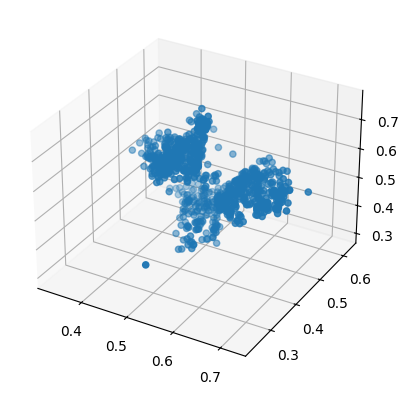

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
predicted_coord_mat_np = predicted_coord_mat.detach().numpy()
ax.scatter(
    predicted_coord_mat_np[0, :],
    predicted_coord_mat_np[1, :],
    predicted_coord_mat_np[2, :],
)
plt.show()